In [1]:
# SQL DB에서 필요한 자료 불러오기

import sqlite3
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

con = sqlite3.connect('.\data\kor_stock.db')

sql = '''
SELECT stock_cd, year, account_nm, fs_value
FROM kor_fs
WHERE ci_div='IND' AND account_nm IN ('*순차입부채', '영업이익') AND year IN ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018');
'''
kor_fs = pd.read_sql(sql, con)

sql = '''
SELECT *
FROM kor_mkt_cap
WHERE date IN ('2011-06-30', '2012-06-29', '2013-06-28', '2014-06-30', '2015-06-30', '2016-06-30', '2017-06-30', '2018-06-29', '2019-06-28');
'''
kor_mkt_cap = pd.read_sql(sql, con)

sql = '''
SELECT stock_cd, stock_nm, unlisted_day, listed_day
FROM kor_ticker
WHERE fn_sec_nm != '금융';
'''
kor_ticker = pd.read_sql(sql, con)

sql = '''
SELECT * 
FROM kor_price 
WHERE SUBSTR(date, 1, 4)||SUBSTR(date, 6, 2)||SUBSTR(date, 9, 2) BETWEEN "20100101" AND "20191231";
'''
kor_price = pd.read_sql(sql, con)

con.close()

In [10]:
# 직전년도말 재무제표 및 6월말 시가총액을 기준으로 EBIT/EV 상위 20종목 추출

import numpy as np

kor_fs['year'] = kor_fs.year.astype('int')
kor_mkt_cap['year'] = kor_mkt_cap.date.str.slice(stop=4).astype('int')

screen_result = pd.DataFrame()

for year in range(2010, 2019):
    
    fs = kor_fs[kor_fs.year==year].pivot(index='stock_cd', columns='account_nm', values='fs_value')
    fs.rename(columns={'*순차입부채':'net_debt', '영업이익':'ebit'}, inplace=True)
    
    mcap = kor_mkt_cap[kor_mkt_cap.year==(year+1)][['stock_cd', 'mkt_cap']]
    
    ebit_to_ev = pd.merge(fs, mcap, left_on=fs.index, right_on='stock_cd', how='left')
    ebit_to_ev = pd.merge(ebit_to_ev, kor_ticker, on='stock_cd', how='inner')
    
    ebit_to_ev = ebit_to_ev[(ebit_to_ev.unlisted_day.isnull()) | (ebit_to_ev.unlisted_day> (str(year+1)+'-07-01'))]    # 상장폐지 종목 삭제
    ebit_to_ev = ebit_to_ev[ebit_to_ev.listed_day <= (str(year+1)+'-07-01')]    # 7월초 현재 상장된 종목만 필터링
    ebit_to_ev['net_debt'] = ebit_to_ev['net_debt'] / 1000
    ebit_to_ev['ebit'] = ebit_to_ev['ebit'] / 1000
    ebit_to_ev['ev'] = ebit_to_ev['net_debt'] + ebit_to_ev['mkt_cap']
    ebit_to_ev['ev'] = np.where(ebit_to_ev.ev<0, 1, ebit_to_ev.ev)    # 보유 현금 및 단기금융상품이 많아 순차입부채가 (-)인 경우 EV가 (-)가 되는 경우도 발생. 이 경우 EV를 1로 설정하여 영업이익이 높은 순으로 순위를 매김. 
    ebit_to_ev['ebit_to_ev_value'] = ebit_to_ev['ebit'] / ebit_to_ev['ev']
    ebit_to_ev['year'] = year    # 재무제표 년도 기준으로 입력
    ebit_to_ev.sort_values('ebit_to_ev_value', ascending=False, inplace=True)
    ebit_to_ev['ebit_to_ev_rank'] = np.round(ebit_to_ev.ebit_to_ev_value.rank(pct=True)*100, 2)
    ebit_to_ev = ebit_to_ev[['year', 'stock_cd', 'stock_nm', 'ebit', 'net_debt', 'mkt_cap', 'ev', 'ebit_to_ev_value', 'ebit_to_ev_rank']]
    
    screen_result = screen_result.append(ebit_to_ev, ignore_index=True)

In [11]:
# EBIT/EV 상위 20종목을 매년 7월초 종가로 매수하여 익년 6월말 매도 반복(동일가중포트)

port_ret_result = pd.DataFrame()
ind_ret_result = pd.DataFrame()

for year in range(2010, 2018):
    
    top_stock = screen_result[(screen_result.year==year)].head(20).stock_cd
    price = kor_price[(kor_price.date >= (str(year+1)+'-07-01')) & 
                      (kor_price.date <= (str(year+2)+'-06-31')) & 
                      kor_price.stock_cd.isin(top_stock)]
    ret = price.pivot(index='date', columns='stock_cd', values='price')
    ret = ret.pct_change(1)
    
    ind_ret = ret + 1
    ind_ret = ind_ret.apply(np.product) - 1
    ind_ret = pd.DataFrame(ind_ret, columns=[year])
    ind_ret.reset_index(inplace=True)
    try:
        ind_ret_result = pd.merge(ind_ret_result, ind_ret, on='stock_cd', how='outer')
    except KeyError:
        ind_ret_result = ind_ret
        
    ret['daily_ret'] = ret.sum(axis=1)/20
    ret.columns.name=''
    ret.reset_index(inplace=True)
    ret = ret[['date', 'daily_ret']]
    port_ret_result = port_ret_result.append(ret, ignore_index=True)
    
port_ret_result['acmlt_ret'] = (1+ port_ret_result.daily_ret).cumprod()
port_ret_result['date'] = pd.to_datetime(port_ret_result['date'])

ind_ret_result = pd.merge(ind_ret_result, kor_ticker[['stock_cd', 'stock_nm']], on='stock_cd', how='left')
col = ind_ret_result.columns.tolist()
ind_ret_result = ind_ret_result[col[-1:]+col[:-1]]

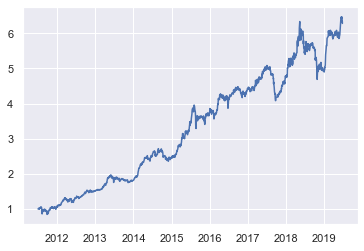

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(port_ret_result['date'], port_ret_result['acmlt_ret'])

In [13]:
port_ret_result.tail(1).acmlt_ret.values

array([6.27879209])

In [14]:
ind_ret_result.iloc[:, 2: ].apply(np.sum)/20

2010   0.24
2011   0.40
2012   0.31
2013   0.49
2014   0.09
2015   0.21
2016   0.08
2017   0.12
dtype: float64

In [15]:
pd.set_option('display.max_rows', None)  
ind_ret_result

,stock_nm,stock_cd,2010,2011,2012,2013,2014,2015,2016,2017
0,삼일기업공사,A002290,-0.04,0.10,0.22,0.28,0.75,-0.26,0.02,0.05
1,방림,A003610,-0.00,nan,nan,nan,nan,nan,nan,nan
2,삼성공조,A006660,0.07,-0.01,0.32,0.00,nan,0.45,-0.24,-0.05
3,대동전자,A008110,-0.08,nan,nan,nan,nan,nan,nan,nan
4,경동인베스트,A012320,0.19,0.37,0.39,-0.00,-0.35,nan,nan,nan
5,동신건설,A025950,-0.27,-0.15,0.46,0.16,nan,nan,nan,nan
6,KG이니시스,A035600,-0.08,nan,nan,nan,nan,nan,nan,nan
7,어울림정보,A038320,0.19,nan,nan,nan,nan,nan,nan,nan
8,에스넷,A038680,1.12,nan,nan,nan,nan,nan,nan,nan
9,파인디지털,A038950,0.37,nan,nan,nan,nan,nan,nan,nan


In [16]:
pd.set_option('display.max_rows', None)  
screen_result[screen_result.year==2018].head(100)

,year,stock_cd,stock_nm,ebit,net_debt,mkt_cap,ev,ebit_to_ev_value,ebit_to_ev_rank
13839,2018,A031980,피에스케이홀딩스,"61,943.76","-104,351.93","50,155.00",1.00,"61,943.76",100.00
13840,2018,A267290,경동도시가스,"43,022.49","-173,931.31","145,050.00",1.00,"43,022.49",99.95
13841,2018,A005710,대원산업,"28,478.65","-145,151.69","127,239.00",1.00,"28,478.65",99.90
13842,2018,A104700,한국철강,"25,413.96","-386,703.50","283,668.00",1.00,"25,413.96",99.85
13843,2018,A029530,신도리코,"18,032.54","-595,308.15","476,281.00",1.00,"18,032.54",99.80
13844,2018,A004890,동일산업,"17,303.91","-160,278.67","148,423.00",1.00,"17,303.91",99.75
13845,2018,A079000,와토스코리아,"2,006.41","-47,766.79","40,968.00",1.00,"2,006.41",99.70
13846,2018,A033560,블루콤,599.48,"-79,671.58","68,735.00",1.00,599.48,99.65
13847,2018,A002460,화성산업,"67,108.17","-157,969.02","170,576.00","12,606.98",5.32,99.60
13848,2018,A115310,인포바인,"13,085.23","-65,984.87","71,201.00","5,216.13",2.51,99.55


In [40]:
dtype = {
    'year':'TEXT',
    'stock_cd':'TEXT',
    'stock_nm':'TEXT',
    'ebit':'INTEGER',
    'mkt_cap':'INTEGER',
    'ev':'REAL',
    'ebit_to_ev_value':'REAL',
    'ebit_to_ev_rank':'REAL'
}
con = sqlite3.connect('.\data\kor_stock.db')
screen_result.to_sql('ebit_to_ev', con, if_exists='replace', index=False, dtype=dtype)